In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import torchvision

In [2]:
path_to_data = '/Users/janbraunsdorff/Studienarbeit-projekt/data'
path_to_validation_annotation = path_to_data + "/validation.csv"
path_to_training_annotation = path_to_data + "/training.csv"
path_to_validatoin_data = path_to_data + '/boneage-validation-dataset/'
path_to_training_data = path_to_data + '/boneage-training-dataset/'
path = path_to_data + '/pickel/v3'

In [3]:
model = torch.load('model/vit.pht', map_location=torch.device('cpu'))
model.eval()
print('**done**')

Device:  cpu
**done**


In [4]:
def processImages(img_path, resize_to=500, reduce_to=380, out_to=256):
    img = cv2.imread(img_path)
    size_target = resize_to
    img = cv2.resize(img, (resize_to, resize_to), interpolation=cv2.INTER_LINEAR)

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


    x = y = (size_target - reduce_to) // 2
    h = w = reduce_to
    img = bgr[y:y + h, x:x + w]

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    kernel = np.ones((2,2),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    img = cv2.resize(img, (out_to, out_to), interpolation=cv2.INTER_LINEAR)

    
    return img

def img_to_tensor(base_path):
    img = processImages(img_path=base_path)
    arr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    t_img = torch.tensor(arr)
    t_img_normalize = t_img.unsqueeze(0)

    return t_img_normalize

In [5]:
#test = torchvision.transforms.functional.crop(img, 0, 0, 128, 128)
#plt.imshow(test.permute(1,2,0).numpy(), cmap='gray')

In [22]:
def getconding(path):
    img = img_to_tensor(path)
    patches = model.patches(img.unsqueeze(0).float())
    encoding = model.encode_patches(patches.float())

    for t in model.transformers:
        x1 = t.norm_1(encoding)
        attention_output = t.mha(x1,x1,x1)
        x2 = attention_output[0] + encoding
        x3 = t.norm_2(x2)
        x3 = t.mlp(x3)
        encoding = x3 + x2

    t = torch.mean(encoding, 2)
    max_value = torch.max(t, dim=1)[0]
    t = t.view(-1, 16, 16)
    t = t / max_value
    t = t.squeeze(0)
    t = t.detach().numpy()
    t2 = t.copy()
    t2[t2<0.5] = 0

    return img, t, t2


<Figure size 144x72 with 0 Axes>

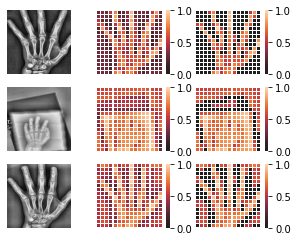

In [23]:
plt.figure(figsize=(2,1))
plt.subplots(figsize=(5,4))

imges = ["1377.png", "1378.png", "1400.png"]

for i in range (3):
    img, t, t2 = getconding(path_to_training_data + imges[i])

    plt.subplot(3, 3, i*3+1)
    plt.imshow(img.permute(1,2,0).detach(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 3, i*3+2)

    ax = sns.heatmap(
        t,
        cbar=True,
        vmin=0, vmax=1,
        annot=False,
        xticklabels=False, 
        yticklabels=False,
        center=0,
        linewidths=.1
    )

    plt.subplot(3, 3, i*3+3)
    ax = sns.heatmap(
        t2,
        cbar=True,
        vmin=0, vmax=1,
        annot=False,
        xticklabels=False, 
        yticklabels=False,
        center=0,
        linewidths=.1
    )